# Time marching

$$
\def\ddt#1{\frac{\mathrm{d}#1}{\mathrm{d}t}}
\renewcommand{\vec}{\boldsymbol}
\newcommand{\uvec}[1]{\vec{\hat{#1}}}
\newcommand{\utangent}{\uvec{\tau}}
\newcommand{\unormal}{\uvec{n}}
\renewcommand{\d}{\,\mathrm{d}}
$$

[ConstrainedSystems.jl](https://github.com/JuliaIBPM/ConstrainedSystems.jl) is equipped with tools for solving systems of equations of the
general form of half-explicit differential-algebraic equations,

$$\ddt y = L y - B_1^T(y,t) z + r_1(y,t), \quad B_2(y,t) y + C(y,t) z = r_2(t), \quad y(0) = y_0$$

where $z$ is the Lagrange multiplier for enforcing the constraints on $y$. Note
that the constraint operators may depend on the state and on time. The linear operator $L$ may be a matrix or a scalar, but is generally independent of time. (The method of integrating factors can deal with time-dependent $L$, but we don't encounter such systems in the constrained systems context so we won't discuss them.) Our objective is to solve
for $y(t)$ and $z(t)$.

In [1]:
using ConstrainedSystems
using CartesianGrids
using Plots

## Constrained integrating factor systems


Let's demonstrate this on the example of heat diffusion from a circular ring whose temperature
is held constant. In this case, $L$ is the discrete Laplace operator times the heat diffusivity,
$r_1$ is zero (in the absence of volumetric heating sources), and $r_2$ is the temperature of
the ring. The operators $B_1^T$ and $B_2$ will be the regularization and interpolation
operators between discrete point-wise data on the ring and the field data. We will also
include a $C$ operator that slightly regularizes the constraint.

The ring will have radius $1/2$ and fixed temperature $1$, and
the heat diffusivity is $1$. (In other words, the problem has been non-dimensionalized
by the diameter of the circle, the dimensional ring temperature, and the dimensional diffusivity.)

First, we will construct a field to accept the temperature on

In [2]:
nx = 129; ny = 129; Lx = 2.0; Δx = Lx/(nx-2);
w₀ = Nodes(Dual,(nx,ny)); # field initial condition

Now set up a ring of points on the circle at center $(1,1)$.

In [3]:
n = 128; θ = range(0,stop=2π,length=n+1);
R = 0.5; xb = 1.0 .+ R*cos.(θ); yb = 1.0 .+ R*sin.(θ);
X = VectorData(xb[1:n],yb[1:n]);
z = ScalarData(X); # to be used as the Lagrange multiplier

Together, `w₀` and `z` comprise the initial solution vector:

In [4]:
u₀ = solvector(state=w₀,constraint=z)

(Dual nodes in a (nx = 129, ny = 129) cell grid of type Float64 data
  Number of Dual nodes: (nx = 129, ny = 129), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

Now set up the operators. We first set up the linear operator, a Laplacian endowed
with its inverse:

In [5]:
L = plan_laplacian(w₀,with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 129, ny = 129) grid acting on Float64 data with
               factor 1.0 and spacing 1.0

Now the right-hand side operators for the ODEs and constraints. Both must take a standard form:
$r_1$ must accept arguments `w₀`, `p` (parameters not used in this problem), and `t`; $r_2$ must accept arguments `p` and `t`. We will implement these in in-place form to make
it more efficient. $r_1$ will return rate-of-change data of the same type as `w₀`
and $r_2$ will return data `dz` of the same type as `z`

In [6]:
diffusion_rhs!(dw::Nodes,w::Nodes,x,p,t) = fill!(dw,0.0) # this is r1
boundary_constraint_rhs!(dz::ScalarData,x,p,t) = fill!(dz,1.0) # this is r2, and sets uniformly to 1

boundary_constraint_rhs! (generic function with 1 method)

Construct the regularization and interpolation operators in their usual
symmetric form, and then set up routines that will provide these operators inside the integrator:

In [7]:
reg = Regularize(X,Δx;issymmetric=true)
Hmat, Emat = RegularizationMatrix(reg,z,w₀)

boundary_constraint_force!(dw::Nodes,z::ScalarData,x,p) = dw .= Hmat*z # This is B1T
boundary_constraint_op!(dz::ScalarData,y::Nodes,x,p) = dz .= Emat*y;  # This is B2

Construct a constraint regularization operator (the $C$ operator)

In [8]:
boundary_constraint_reg!(dz::ScalarData,z::ScalarData,x,p) = dz .= -0.1*z; # This is C

Note that these last two functions are also in-place, and return data of the same
respective types as $r_1$ and $r_2$.

All of these are assembled into a single `ConstrainedODEFunction`:

In [9]:
f = ConstrainedODEFunction(diffusion_rhs!,boundary_constraint_rhs!,boundary_constraint_force!,
                          boundary_constraint_op!,L,boundary_constraint_reg!,_func_cache=u₀)

Constrained ODE function of in-place type and static constraints


With the last argument, we supplied a cache variable to enable evaluation of this function.

Now set up the problem, using the same basic notation as in [DifferentialEquations.jl](https://github.com/SciML/DifferentialEquations.jl).

In [10]:
tspan = (0.0,20.0)
prob = ODEProblem(f,u₀,tspan)

ODEProblem with uType ArrayPartition{Float64, Tuple{Nodes{Dual, 129, 129, Float64, Matrix{Float64}}, ScalarData{128, Float64, Vector{Float64}}}} and tType Float64. In-place: true
timespan: (0.0, 20.0)
u0: (Dual nodes in a (nx = 129, ny = 129) cell grid of type Float64 data
  Number of Dual nodes: (nx = 129, ny = 129), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

Now solve it. We will set the time-step size to a large value ($1.0$) for demonstration purposes. The method remains stable for any choice.

In [11]:
Δt = 1.0
sol = solve(prob,IFHEEuler(),dt=Δt);

Now let's plot it

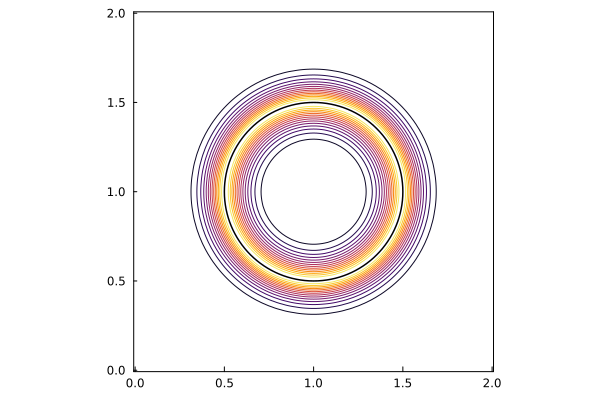

In [12]:
xg, yg = coordinates(w₀,dx=Δx);
plot(xg,yg,state(sol.u[end]))
plot!(xb,yb,linecolor=:black,linewidth=1.5)

From a side view, we can see that it enforces the boundary condition:

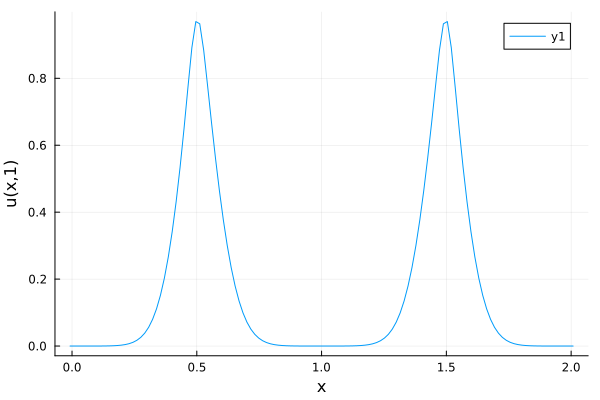

In [13]:
plot(xg,state(sol.u[end])[65,:],xlabel="x",ylabel="u(x,1)")

The Lagrange multiplier distribution is nearly uniform

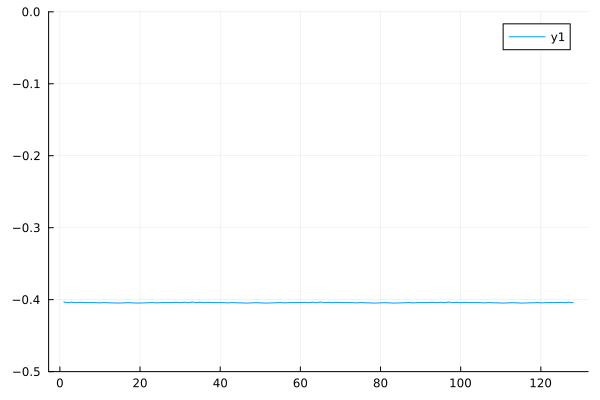

In [14]:
plot(constraint(sol.u[end]),ylim=(-0.5,0))

## Systems with variable constraints

In some cases, the constraint operators may vary with the state vector. A
good example of this is a swinging pendulum, with its equations expressed in
Cartesian coordinates. The constraint we wish to enforce is that the length
of the pendulum is constant: $x^2+y^2 = l^2$. Though not mathematically necessary,
it also helps to enforce a tangency condition, $xu + yv = 0$, where $u$ and $v$
are the rates of change of $x$ and $y$. Note that this is simply the derivative
of the first constraint. (If expressed in cylindrical coordinates, the constraint is enforced
automatically, simply by expressing the equations for $\theta$.)

The governing equations are

$$\ddt x = u - x \mu ,\, \ddt y = v - y \mu , \, \ddt u = -x \lambda , \, \ddt v = -g - y\lambda$$

with Lagrange multipliers $\mu$ and $\lambda$, and the constraints are

$$x^2+y^2 = l^2,\, xu + yu = 0$$

These are equivalently expressed as

$$\left[ \begin{array}{cccc} x & y & 0 & 0\end{array}\right]\left[ \begin{array}{c} x \\ y \\ u \\ v \end{array}\right] = l^2$$

and

$$\left[ \begin{array}{cccc} 0 & 0 & x & y\end{array}\right]\left[ \begin{array}{c} x \\ y \\ u \\ v \end{array}\right] = 0$$

The operators $B_1^T$ and $B_2$ are thus

$$B_1^T = \left[ \begin{array}{cc} x & 0 \\ y & 0 \\ 0 & x \\ 0 & y \end{array}\right]$$

and

$$B_2 = \left[ \begin{array}{cccc} x & y & 0 & 0 \\ 0 & 0 & x & y \end{array}\right]$$

That is, the operators are dependent on the state. In this package, we handle this
by providing a parameter that can be dynamically updated. We will get to that later. First,
let's set up the physical parameters

In [15]:
l = 1.0
g = 1.0
params = [l,g]

2-element Vector{Float64}:
 1.0
 1.0

and initial condition:

In [16]:
θ₀ = π/2
y₀ = Float64[l*sin(θ₀),-l*cos(θ₀),0,0]
z₀ = Float64[0.0, 0.0] # Lagrange multipliers
u₀ = solvector(state=y₀,constraint=z₀)

([1.0, -6.123233995736766e-17, 0.0, 0.0], [0.0, 0.0])

Now, we will set up the basic form of the constraint operators and assemble
these with the other parameters with the help of a type we'll define here:

In [17]:
struct ProblemParams{P,BT1,BT2}
    params :: P
    B₁ᵀ :: BT1
    B₂ :: BT2
end

B1T = zeros(4,2) # set to zeros for now
B2 = zeros(2,4)  # set to zeros for now
p₀ = ProblemParams(params,B1T,B2);

We will now define the operators of the problem, all in in-place form:

In [18]:
function pendulum_rhs!(dy::Vector{Float64},y::Vector{Float64},x,p,t)
    dy[1] = y[3]
    dy[2] = y[4]
    dy[3] = 0.0
    dy[4] = -p.params[2]
    return dy
end # r1

function length_constraint_rhs!(dz::Vector{Float64},x,p,t)
    dz[1] = p.params[1]^2
    dz[2] = 0.0
    return dz
end # r2

length_constraint_rhs! (generic function with 1 method)

The B1 function. This returns B1*z. It uses an existing B1 supplied by p.

In [19]:
function length_constraint_force!(dy::Vector{Float64},z::Vector{Float64},x,p)
    dy .= p.B₁ᵀ*z
end

length_constraint_force! (generic function with 1 method)

The B2 function. This returns B2*y. It uses an existing B2 supplied by p.

In [20]:
function length_constraint_op!(dz::Vector{Float64},y::Vector{Float64},x,p)
    dz .= p.B₂*y
end

length_constraint_op! (generic function with 1 method)

Now, we need to provide a means of updating the parameter structure with
the current state of the system. This is done in-place, just as for the
other operators:

In [21]:
function update_p!(q,u,p,t)
    y = state(u)
    fill!(q.B₁ᵀ,0.0)
    fill!(q.B₂,0.0)
    q.B₁ᵀ[1,1] = y[1]; q.B₁ᵀ[2,1] = y[2]; q.B₁ᵀ[3,2] = y[1]; q.B₁ᵀ[4,2] = y[2]
    q.B₂[1,1] = y[1]; q.B₂[1,2] = y[2]; q.B₂[2,3] = y[1]; q.B₂[2,4] = y[2]
    return q
end

update_p! (generic function with 1 method)

Finally, assemble all of them together:

In [22]:
f = ConstrainedODEFunction(pendulum_rhs!,length_constraint_rhs!,length_constraint_force!,
                                length_constraint_op!,
                               _func_cache=deepcopy(u₀),param_update_func=update_p!)

Constrained ODE function of in-place type and variable constraints


Now solve the system

In [23]:
tspan = (0.0,10.0)
prob = ODEProblem(f,u₀,tspan,p₀)

Δt = 1e-2
sol = solve(prob,LiskaIFHERK(),dt=Δt);

Plot the solution

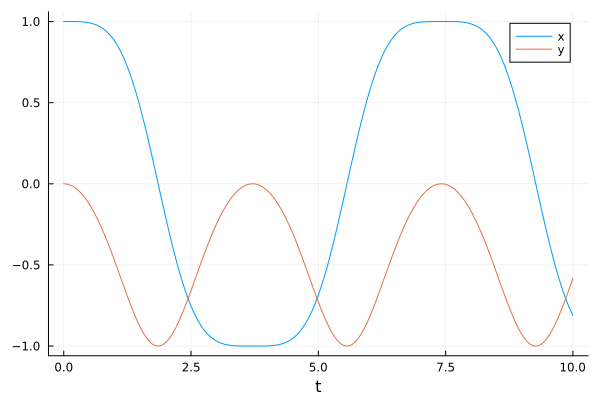

In [24]:
plot(sol.t,sol[1,:],label="x",xlabel="t")
plot!(sol.t,sol[2,:],label="y")

and here is the trajectory

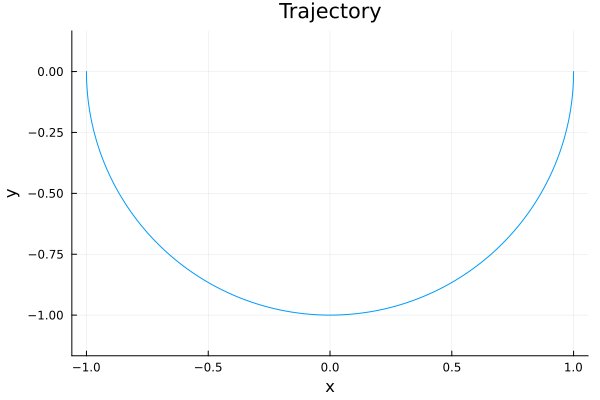

In [25]:
plot(sol[1,:],sol[2,:],ratio=1,legend=:false,title="Trajectory",xlabel="x",ylabel="y")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*